In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [171]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# Wczytanie danych
(interwał dzienny)


In [172]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])

In [173]:
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [174]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [175]:
ropa.dtypes

Data                       object
Cena ropy [USD/Barrel]    float64
dtype: object

In [176]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

In [177]:
gaz.dtypes

Data                           datetime64[ns]
Cena gazu [USD/Million Btu]           float64
dtype: object

In [178]:
df = gaz.merge(ropa, on="Data", how="inner").dropna() # zbiorcza tabela połączona po danych - do analizy dwuwymiarowej
df = df.sort_values(['Data'], ascending=[True])

In [179]:
df = df.reset_index(drop=True)
df.head()

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel]
0,2007-07-30,6.4990,75.7400
1,2007-07-31,6.1910,77.0500
2,2007-08-01,6.3520,75.3500
3,2007-08-02,6.1060,75.7600
4,2007-08-03,6.0900,74.7500


In [180]:
y_gaz = df['Cena gazu [USD/Million Btu]']
y_ropa = df['Cena ropy [USD/Barrel]']

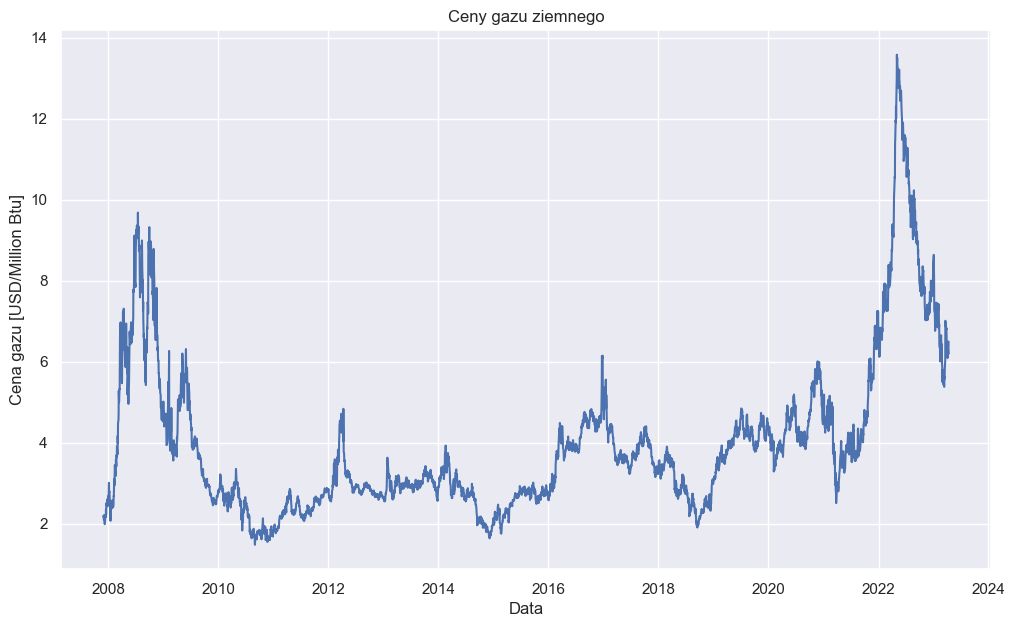

In [181]:
sns.lineplot(x=gaz.Data, y=y_gaz)
plt.title('Ceny gazu ziemnego')
plt.xlabel('Data')
# plt.savefig('ceny_gazu.png')
plt.show()

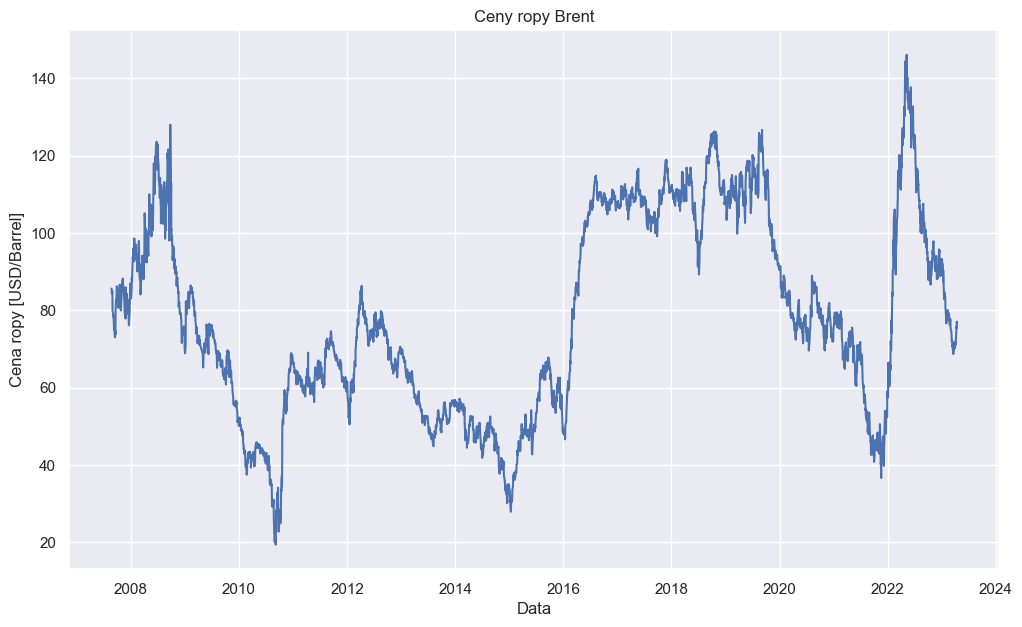

In [182]:
sns.lineplot(x=ropa.Data, y=y_ropa)
plt.title('Ceny ropy Brent')
plt.xlabel('Data')
# plt.savefig('ceny_ropy.png')
plt.show()

### Przygotowanie danych

Zwroty logarytmiczne
$$ y_t = \ln(\frac{x_t}{x_{t-1}})$$

In [183]:
df['przyrosty_log_gaz'] = np.log(y_gaz).diff().dropna()
df['przyrosty_log_ropa'] = np.log(y_ropa).diff().dropna()

In [184]:
df.shape

(3873, 5)

In [185]:
df.dropna(inplace=True)

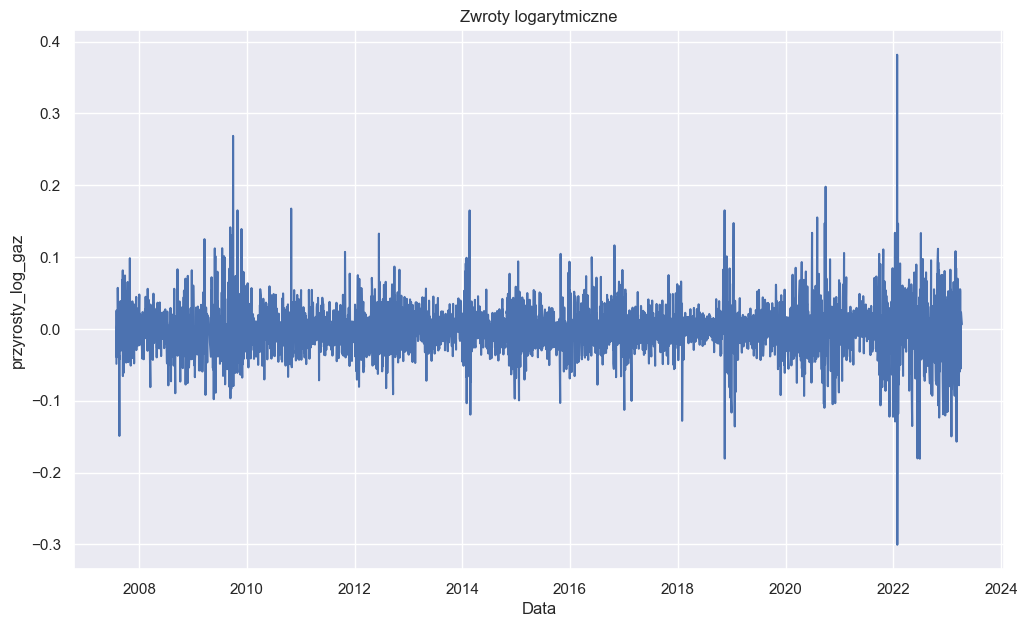

In [186]:
sns.lineplot(x=df.Data, y=df.przyrosty_log_gaz)
plt.title('Zwroty logarytmiczne')
plt.xlabel('Data')
# plt.savefig('log_przyrosty_gazu.png')
plt.show()

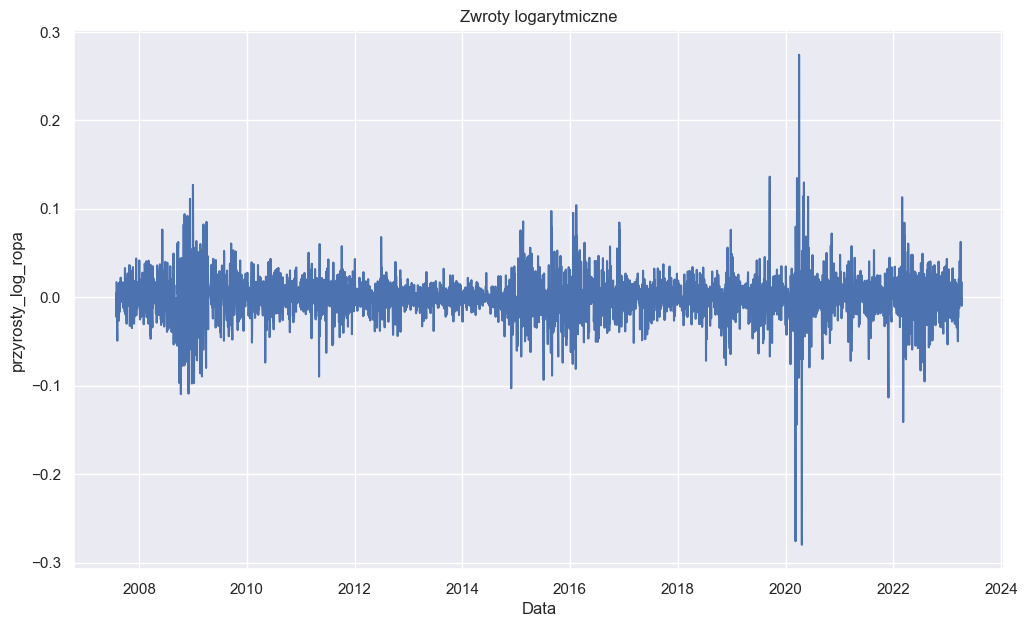

In [187]:
sns.lineplot(x=df.Data, y=df.przyrosty_log_ropa)
plt.title('Zwroty logarytmiczne')
plt.xlabel('Data')
# plt.savefig('log_przyrosty_ropy.png')
plt.show()

### Stacjonarność przyrostów logarytmicznych

In [188]:
def adf_test(x):
    p_val = []
    trend = ['Stała', 'Linia', 'Parabola', 'Brak']
    trends = ['c', 'ct', 'ctt', 'nc']
    for i in trends:
        p_val.append(adfuller(x, regression=i)[1])
    return pd.DataFrame({'Trend': trend, 'P-value':p_val})

In [189]:
adf_test(df.przyrosty_log_gaz.dropna())

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


,Trend,P-value
0,Stała,0.0000
1,Linia,0.0000
2,Parabola,0.0000
3,Brak,0.0000


In [190]:
adf_test(df.przyrosty_log_ropa.dropna())

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


,Trend,P-value
0,Stała,0.0000
1,Linia,0.0000
2,Parabola,0.0000
3,Brak,0.0000


p-wartość < 0.05 => przyrosty są stacjonarne
# Analiza jednowymiarowa
- miary zmienności w koncepcji neutralnej: (odch. stadard., odch. przeciętne)
- miary zmienności w koncepcji negatywnej: (semiodch. standard., semiodch. przeciętne)
- miary rozproszenia (rozstęp międzykwantylowy)
- kwantyle rozkładu
- wartość dystrybuanty rozkładu

## Gaz ziemny

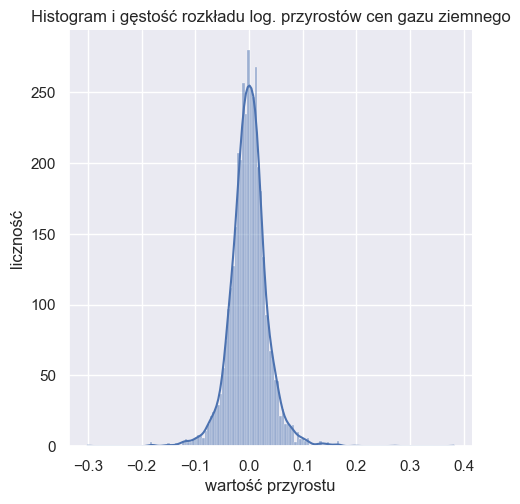

In [191]:
sns.displot(x=df.przyrosty_log_gaz, kde=True)
plt.title('Histogram i gęstość rozkładu log. przyrostów cen gazu ziemnego')
plt.xlabel('wartość przyrostu')
plt.ylabel('liczność')
# plt.savefig('histogram_gaz.png')
plt.show()

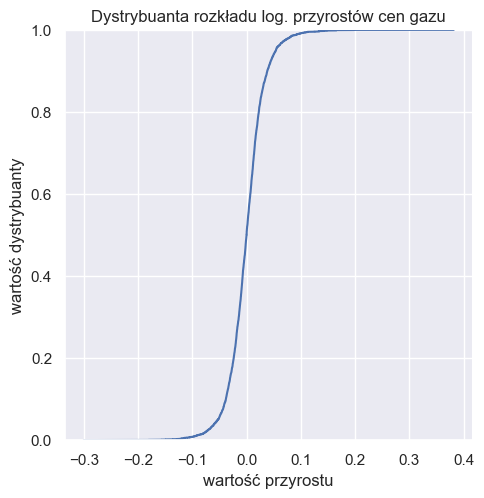

In [192]:
sns.displot(x=df.przyrosty_log_gaz, kind='ecdf')
plt.title('Dystrybuanta rozkładu log. przyrostów cen gazu')
plt.xlabel('wartość przyrostu')
plt.ylabel('wartość dystrybuanty')
# plt.savefig('dystr_gaz.png')
plt.show()

## Podejście parametryczne

#### Próba dopasowania rozkładu normalnego

In [193]:
loc, sc = st.norm.fit(df.przyrosty_log_gaz)
loc, sc

(-0.0002813984837701097, 0.03535087007742996)

In [194]:
np.var(df.przyrosty_log_gaz)

0.0012496840152313325

#### Testy na normalność

In [195]:
kstest(df.przyrosty_log_gaz, 'norm', args=(loc, sc))

KstestResult(statistic=0.06421852394149152, pvalue=2.5157569964831075e-14)

In [196]:
st.normaltest(df.przyrosty_log_gaz)

NormaltestResult(statistic=675.3881800798168, pvalue=2.1944218773445535e-147)

In [197]:
st.shapiro(df.przyrosty_log_gaz)

ShapiroResult(statistic=0.9409440159797668, pvalue=8.863976438465586e-37)

#### => nie jest normalny
#### Próba dopasowania rozkładu lognormalnego

In [198]:
shape, loc, scale = st.lognorm.fit(df.przyrosty_log_gaz)

In [199]:
kstest(df.przyrosty_log_gaz, st.lognorm(shape, loc, sc).cdf)

KstestResult(statistic=1.0, pvalue=0.0)

#### Próba dopasowania rozkładu laplace'a

In [200]:
loc, sc = st.laplace.fit(df.przyrosty_log_gaz)
loc, sc

(-0.0002884305077053284, 0.025058451102618014)

In [201]:
kstest(df.przyrosty_log_gaz, st.laplace(loc, sc).cdf)

KstestResult(statistic=0.027381252116725874, pvalue=0.00590664527540545)

### Próba dopasowania rozkładu t-studenta

In [202]:
d_f, loc, sc = st.t.fit(df.przyrosty_log_gaz)

In [203]:
st.ttest_1samp(df.przyrosty_log_gaz, popmean=loc)

Ttest_1sampResult(statistic=0.3754696160243694, pvalue=0.7073318113703851)

In [204]:
kstest(df.przyrosty_log_gaz, st.t(d_f, loc, sc).cdf)

KstestResult(statistic=0.009431514088623527, pvalue=0.877834695973416)

In [205]:
d_f, loc, sc

(3.8729124344360066, -0.0004947340772053391, 0.02484098713608527)

## Rozkład t-Studenta z 4 stopniami swobody

In [206]:
kstest(df.przyrosty_log_gaz, st.t(4, loc, sc).cdf)

KstestResult(statistic=0.009676115109555905, pvalue=0.8579291735708059)

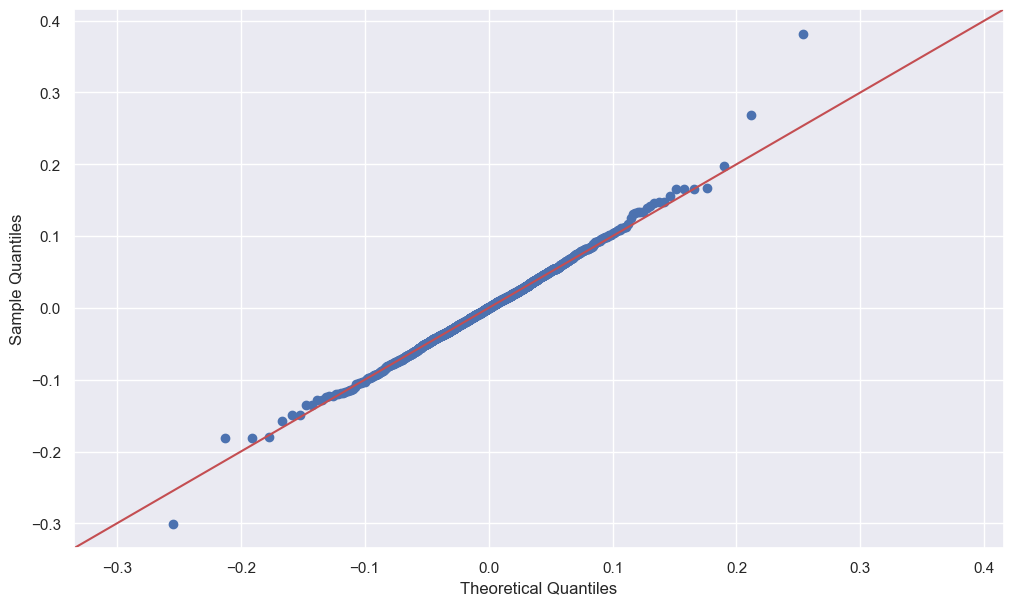

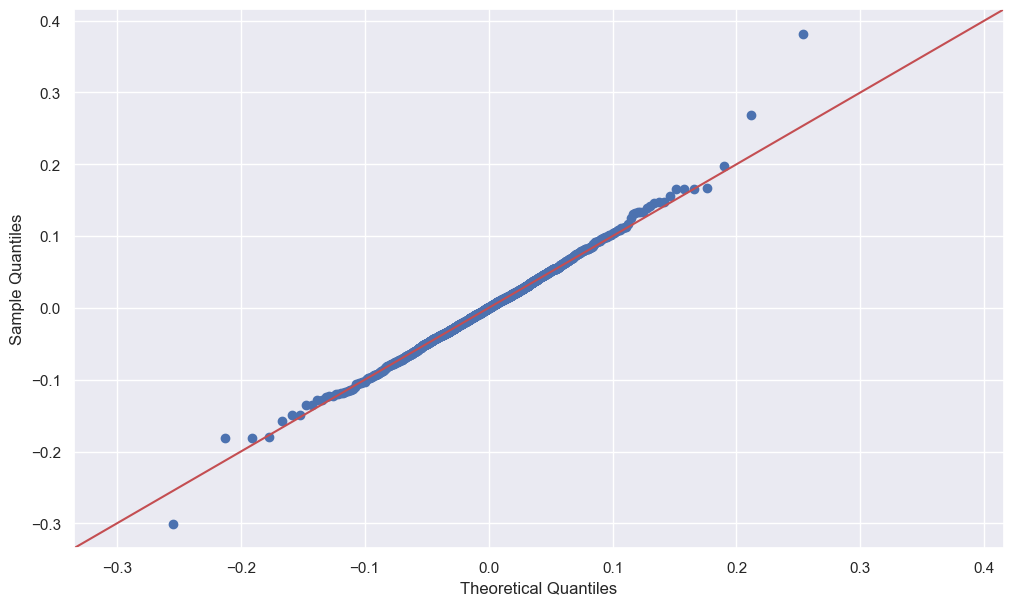

In [207]:
import statsmodels.api as sm
sm.qqplot(df.przyrosty_log_gaz, dist=st.t(4, loc, sc), line='45')

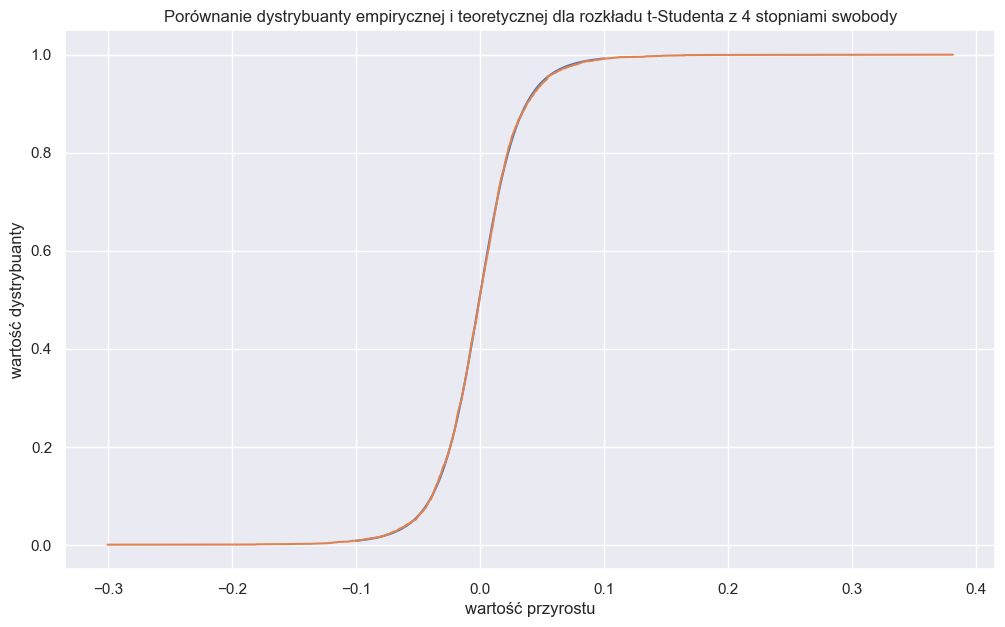

In [208]:
# dystrybuanta teoretyczna
x = np.linspace(-0.1, 0.1, 1000)
f = st.t(4, loc, sc).cdf(x)
plt.plot(x, f)
# empiryczna
sns.lineplot(x=df.przyrosty_log_gaz
         , y=ECDF(df.przyrosty_log_gaz.values.flatten())(df.przyrosty_log_gaz.values.flatten()))
plt.title("Porównanie dystrybuanty empirycznej i teoretycznej dla rozkładu t-Studenta z 4 stopniami swobody")
plt.xlabel('wartość przyrostu')
plt.ylabel('wartość dystrybuanty')
plt.show()

# Podejście nieparametryczne

In [232]:
def parametry(X):
    '''funkcja zwraca tabele z wynikami'''
    # główne parametry
    mean = np.mean(X)
    n = len(X)
    
    # odchylenie standardow
    std = np.std(X)
    # odchylenie przeciętne
    przec_std = np.sum(np.abs(X - mean)) / (n-1)
    
    # rozstęp międzykwartylowy
    q = np.quantile(X, [0.25, 0.75])
    rozstep = q[0]-q[1]

    # odchylenie ćwiartkowe
    cwiartk = (q[1] - q[0]) / 2
    
    # semiodchylenie standardowe
    semi_std = np.sqrt(np.sum(X[X -mean>0] ** 2) / (n-1) )
    # semidochylenie przeciętne
    semi_przec = np.sum(np.abs(X[X -mean>0] - mean)) / (n-1)

    # współczynnik zmienności
    zmiennosc = std/mean

    nazwy = ['Odchylenie standardowe', 'Odchylenie przeciętne', 'Rozstęp międzykwartylowy', 'Odchylenie ćwiartkowe', 
             'Semiodchylenie standardowe', 'Semiodchylenie przeciętne', 'Średnia', 'Współczynnik zmienności']
    wartosci = [std, przec_std, rozstep, cwiartk, semi_std, semi_przec, mean, zmiennosc]
    data = pd.DataFrame({'Miara':nazwy, 'Wartość':wartosci})
    return data

In [233]:
parametry(df.przyrosty_log_gaz)

,Miara,Wartość
0,Odchylenie standardowe,0.0354
1,Odchylenie przeciętne,0.0251
2,Rozstęp międzykwartylowy,-0.0366
3,Odchylenie ćwiartkowe,0.0183
4,Semiodchylenie standardowe,0.0253
5,Semiodchylenie przeciętne,0.0125
6,Średnia,-0.0003
7,Współczynnik zmienności,-125.6257


## kwantyle

In [212]:
def kwantyle(df, levels_df=[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]):
    # wykres
    levels = np.arange(0.01, 1, 0.01)
    q = np.quantile(df, levels)
    sns.lineplot(x=levels, y=q)
    plt.title('Wykres kwantylowy')
    plt.show()
    
    # tabela z wynikami
    q = np.quantile(df, levels_df)
    data = pd.DataFrame({'Kwantyl':levels_df, 'Wartość':q})
    return data

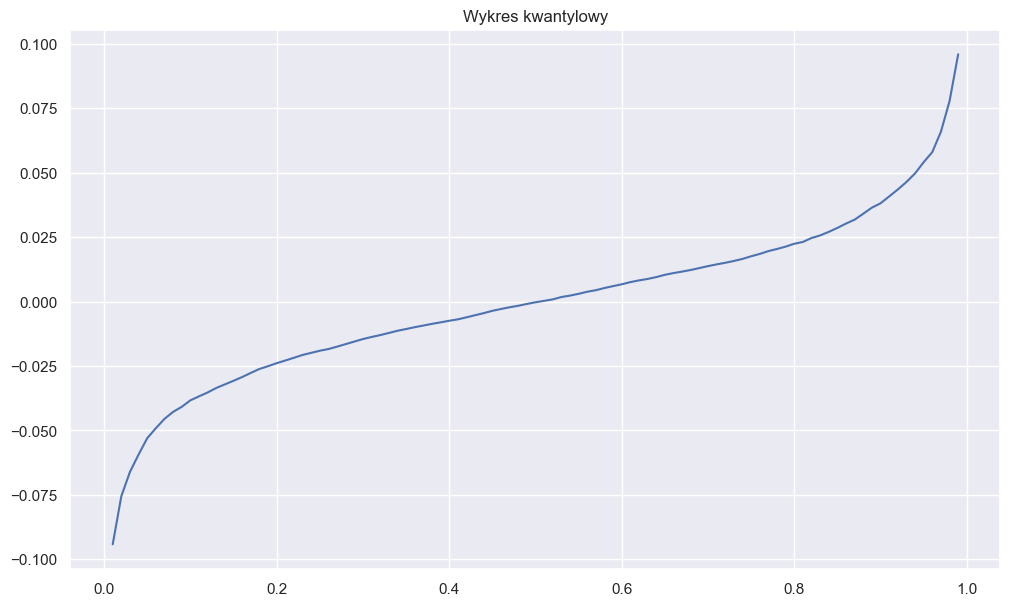

,Kwantyl,Wartość
0,0.0500,-0.0530
1,0.1500,-0.0308
2,0.2500,-0.0191
3,0.3500,-0.0107
4,0.4500,-0.0036
5,0.5500,0.0030
6,0.6500,0.0104
7,0.7500,0.0176
8,0.8500,0.0286
9,0.9500,0.0541


In [213]:
kwantyle(df.przyrosty_log_gaz)

## Wartości dystrybuanty

In [214]:
def wartosc_dystrybuanty(df, wartosci=[0.01, 0.02, 0.05, 0.1, 0.15, 0.2]):

    X = df.values.flatten()
    # empiryczna dystrybuanta
    ecdf = ECDF(X)
    data = pd.DataFrame({'Ustalona wartość':wartosci, 'wartość dystrybuanty':ecdf(wartosci)})
    return data

In [215]:
wartosc_dystrybuanty(df.przyrosty_log_gaz)

,Ustalona wartość,wartość dystrybuanty
0,0.0100,0.6459
1,0.0200,0.7753
2,0.0500,0.9409
3,0.1000,0.9915
4,0.1500,0.9979
5,0.2000,0.9995


# Ropa

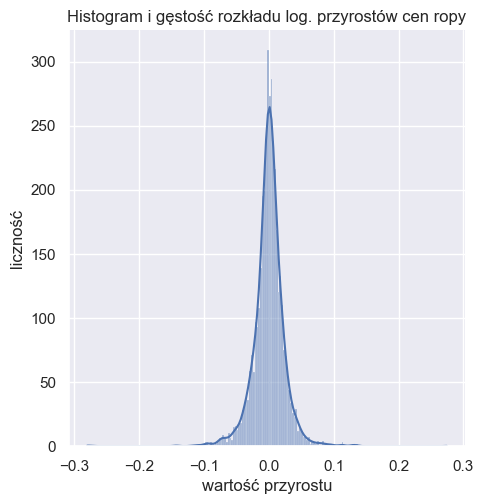

In [216]:
sns.displot(x=df.przyrosty_log_ropa, kde=True)
plt.title('Histogram i gęstość rozkładu log. przyrostów cen ropy')
plt.xlabel('wartość przyrostu')
plt.ylabel('liczność')
# plt.savefig('histogram_ropa.png')
plt.show()

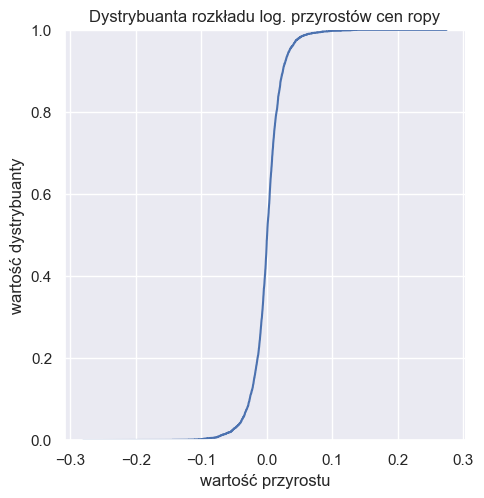

In [217]:
sns.displot(x=df.przyrosty_log_ropa, kind='ecdf')
plt.title('Dystrybuanta rozkładu log. przyrostów cen ropy')
plt.xlabel('wartość przyrostu')
plt.ylabel('wartość dystrybuanty')
# plt.savefig('dystr_gaz.png')
plt.show()

## Podejście parametryczne

#### Próba dopasowania rozkładu normalnego

In [218]:
loc, sc = st.norm.fit(df.przyrosty_log_ropa)
loc, sc

(3.163628003118414e-05, 0.024701626503869204)

#### Testy na normalność

In [219]:
kstest(df.przyrosty_log_ropa, 'norm', args=(loc, sc))

KstestResult(statistic=0.09126908869812259, pvalue=1.6167497323088143e-28)

In [220]:
st.shapiro(df.przyrosty_log_ropa)

ShapiroResult(statistic=0.8931660652160645, pvalue=1.401298464324817e-45)

#### => nie jest normalny
#### Próba dopasowania rozkładu lognormalnego

In [221]:
shape, loc, scale = st.lognorm.fit(df.przyrosty_log_ropa)

In [222]:
kstest(df.przyrosty_log_gaz, st.lognorm(shape, loc, sc).cdf)

KstestResult(statistic=1.0, pvalue=0.0)

### Próba dopasowania rozkładu t-studenta

In [223]:
d_f, loc, sc = st.t.fit(df.przyrosty_log_ropa)

In [224]:
kstest(df.przyrosty_log_ropa, st.t(d_f, loc, sc).cdf)

KstestResult(statistic=0.01772676784893891, pvalue=0.17328565840552979)

In [225]:
d_f, loc, sc

(2.7649667165377894, 0.0007623529414043834, 0.014532256304918206)

sprawdzam dla 3 stopni swobody

In [226]:
kstest(df.przyrosty_log_ropa, st.t(3, loc, sc).cdf)

KstestResult(statistic=0.02159634945730597, pvalue=0.05322338480526545)

## Rozkład t-Studenta z 3 stopniami swobody

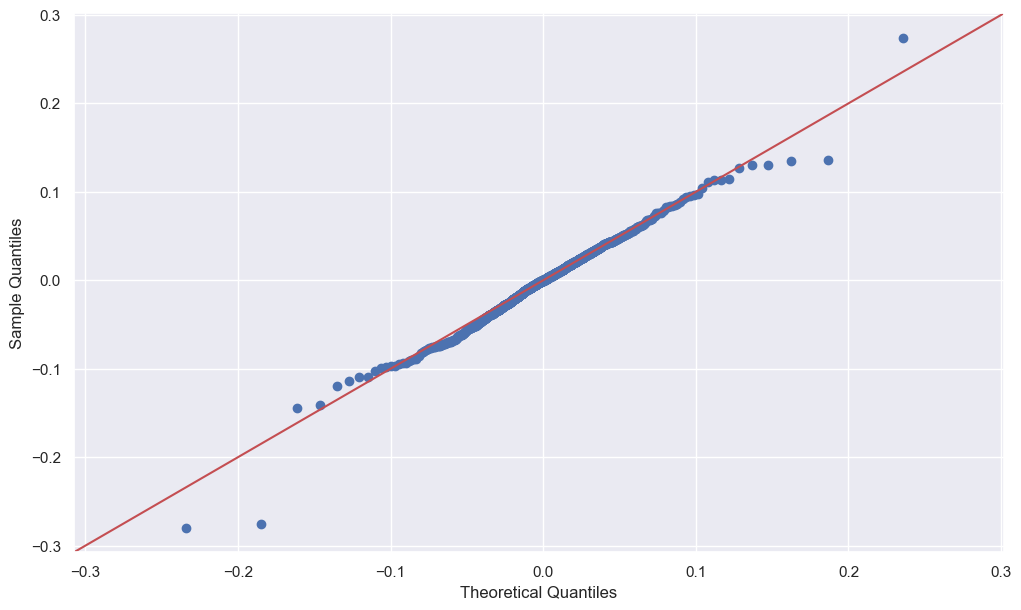

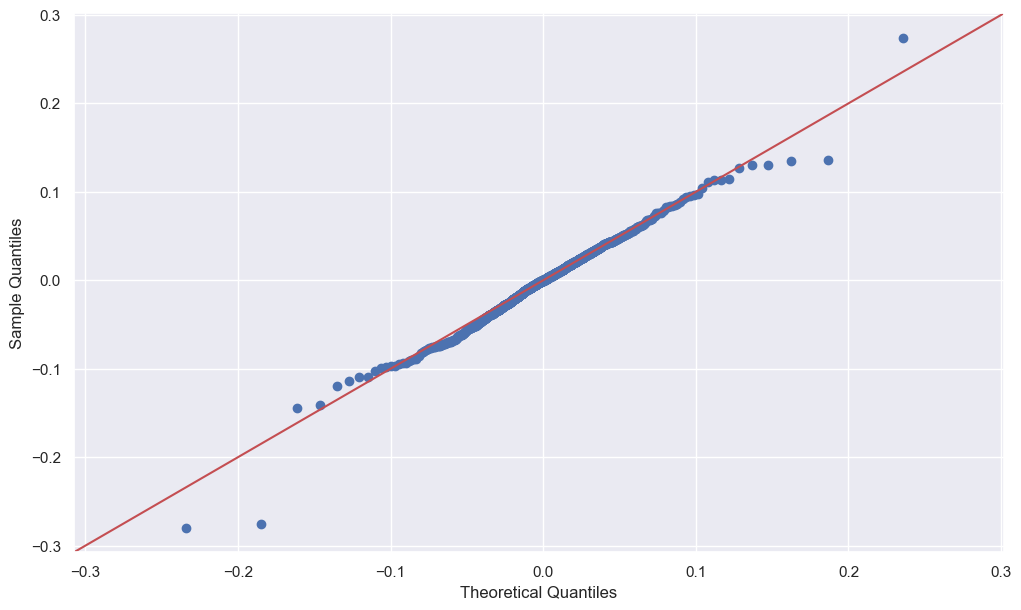

In [227]:
sm.qqplot(df.przyrosty_log_ropa, dist=st.t(3, loc, sc), line='45')

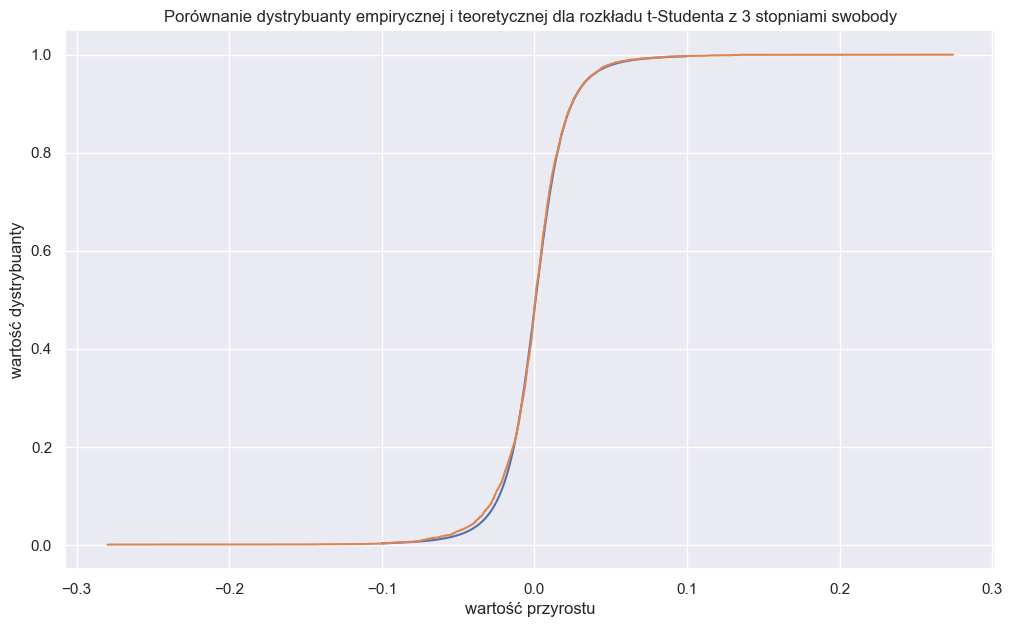

In [228]:
# dystrybuanta teoretyczna
x = np.linspace(-0.1, 0.1, 1000)
f = st.t(3, loc, sc).cdf(x)
plt.plot(x, f)
# empiryczna
sns.lineplot(x=df.przyrosty_log_ropa
         , y=ECDF(df.przyrosty_log_ropa.values.flatten())(df.przyrosty_log_ropa.values.flatten()))
plt.title("Porównanie dystrybuanty empirycznej i teoretycznej dla rozkładu t-Studenta z 3 stopniami swobody")
plt.xlabel('wartość przyrostu')
plt.ylabel('wartość dystrybuanty')
plt.show()

## Podejście nieparametryczne

In [234]:
parametry(df.przyrosty_log_ropa)

,Miara,Wartość
0,Odchylenie standardowe,0.0247
1,Odchylenie przeciętne,0.0163
2,Rozstęp międzykwartylowy,-0.0216
3,Odchylenie ćwiartkowe,0.0108
4,Semiodchylenie standardowe,0.0169
5,Semiodchylenie przeciętne,0.0082
6,Średnia,0.0000
7,Współczynnik zmienności,780.8006


## kwantyle

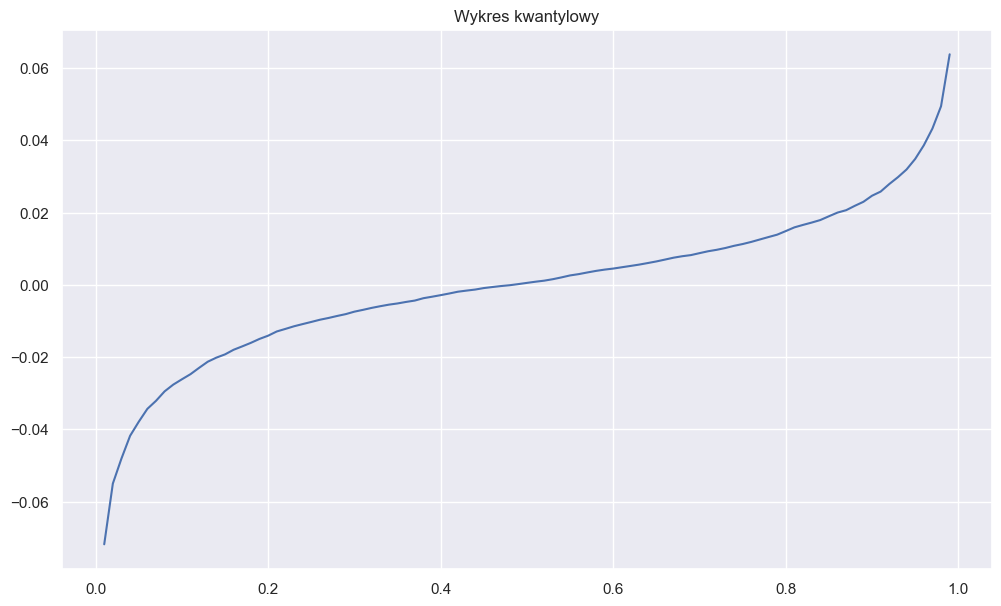

,Kwantyl,Wartość
0,0.0500,-0.0379
1,0.1500,-0.0192
2,0.2500,-0.0103
3,0.3500,-0.0051
4,0.4500,-0.0009
5,0.5500,0.0026
6,0.6500,0.0065
7,0.7500,0.0113
8,0.8500,0.0190
9,0.9500,0.0348


In [235]:
kwantyle(df.przyrosty_log_ropa)

## Wartości dystrybuanty

In [236]:
wartosc_dystrybuanty(df.przyrosty_log_ropa)

,Ustalona wartość,wartość dystrybuanty
0,0.0100,0.7265
1,0.0200,0.8600
2,0.0500,0.9806
3,0.1000,0.9972
4,0.1500,0.9997
5,0.2000,0.9997
